In [92]:
# import the serious stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [93]:
# create random images
no_of_images = 50000
image_size = 8
min_object_size = 1
max_object_size = 4
no_of_objects = 1 # number of squares in an image

# stores list of boundary of every object
bounding_boxes = np.zeros((no_of_images, no_of_objects, 4))

# list of images
images = np.zeros((no_of_images, image_size, image_size))

for i_image in range(no_of_images):
    for i_object in range(no_of_objects):
        # size is the no of random variables to be generated
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, image_size - w)
        y = np.random.randint(0, image_size - h)
        images[i_image, x:x+w, y:y+h] = 1.
        bounding_boxes[i_image, i_object] = [x, y, w, h]

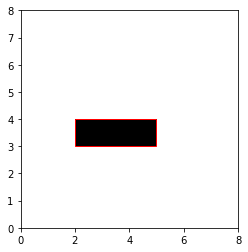

In [94]:
# debug
# .T does diagonal transform
plt.imshow(images[0].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, image_size, 0, image_size])
for bounding_box in bounding_boxes[0]:
    # apparently draws bounding boxes
    plt.gca().add_patch(matplotlib.patches.Rectangle((bounding_box[0], bounding_box[1]), bounding_box[2], bounding_box[3], ec='r', fc='none'))

In [95]:
# normalize data to mean 0 and std 1, -1 means dimension is unknown
X = (images.reshape(no_of_images, -1) - np.mean(images) / np.std(images))
print(X.shape, np.mean(X), np.std(X))

# normalize x, y, w, h by image_size, so all values are between 0 and 1
y = bounding_boxes.reshape(no_of_images, -1) / image_size
print(y.shape, np.mean(y), np.std(y))

(50000, 64) -0.19558601861594122 0.24189193860262787
(50000, 4) 0.281231875 0.17545153706646283


In [96]:
# split training and test dataset
split = int(0.8 * no_of_images)
train_X = X[:split]
test_X = X[split:]
train_y = y[:split]
test_y = y[split:]

# test images
test_images = images[split:]
test_boxes = bounding_boxes[split:]

In [97]:
# build the model
model = Sequential([
    Dense(300, input_dim=X.shape[-1]),
    Activation('relu'),
    Dropout(0.2),
    Dense(y.shape[-1])
])
model.compile('adadelta', 'mse')

In [98]:
# visualization
callback = keras.callbacks.TensorBoard(log_dir='./graph',
                                      histogram_freq=0,
                                      write_graph=True,
                                      write_images=True)

In [99]:
# train the model
model.fit(train_X, train_y, epochs=50, validation_data=(test_X, test_y), verbose=2, callbacks=[callback])

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
 - 2s - loss: 0.0053 - val_loss: 0.0010
Epoch 2/50
 - 2s - loss: 0.0020 - val_loss: 5.8135e-04
Epoch 3/50
 - 2s - loss: 0.0014 - val_loss: 3.6782e-04
Epoch 4/50
 - 2s - loss: 0.0011 - val_loss: 2.9965e-04
Epoch 5/50
 - 2s - loss: 9.7681e-04 - val_loss: 2.0127e-04
Epoch 6/50
 - 2s - loss: 8.5542e-04 - val_loss: 1.5217e-04
Epoch 7/50
 - 2s - loss: 7.6628e-04 - val_loss: 1.1508e-04
Epoch 8/50
 - 3s - loss: 7.0635e-04 - val_loss: 1.2354e-04
Epoch 9/50
 - 2s - loss: 6.6948e-04 - val_loss: 9.7753e-05
Epoch 10/50
 - 2s - loss: 6.3566e-04 - val_loss: 8.1403e-05
Epoch 11/50
 - 3s - loss: 6.0432e-04 - val_loss: 5.8302e-05
Epoch 12/50
 - 2s - loss: 5.8313e-04 - val_loss: 5.6859e-05
Epoch 13/50
 - 2s - loss: 5.6334e-04 - val_loss: 4.5229e-05
Epoch 14/50
 - 2s - loss: 5.4491e-04 - val_loss: 6.2856e-05
Epoch 15/50
 - 2s - loss: 5.2878e-04 - val_loss: 6.6595e-05
Epoch 16/50
 - 2s - loss: 5.1318e-04 - val_loss: 3.8412e-05
Epoch 17/50
 - 2s -

In [100]:
# predict bounding boxes for test data
predicted_y = model.predict(test_X)
predicted_boxes = predicted_y * image_size
predicted_boxes = predicted_boxes.reshape(len(predicted_boxes), no_of_objects, -1)
predicted_boxes.shape

(10000, 1, 4)

In [101]:
# calculate overlap between two bounding boxes
def IOU(box_1, box_2):
    x1, y1, w1, h1 = box_1[0], box_1[1], box_1[2], box_1[3]
    x2, y2, w2, h2 = box_2[0], box_2[1], box_2[2], box_2[3]
    
    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    
    if w_I <= 0 or h_I <= 0: # no overlap
        return 0
    
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    
    return I/U

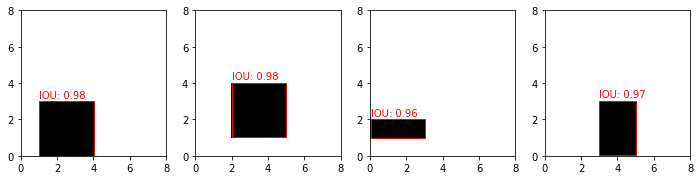

In [102]:
# draw sample predictions
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_images))
    plt.imshow(test_images[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, image_size, 0, image_size])
    
    for predicted_box, expected_box in zip(predicted_boxes[i], test_boxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((predicted_box[0], predicted_box[1]), predicted_box[2], predicted_box[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(predicted_box, expected_box)), (predicted_box[0], predicted_box[1] + predicted_box[3] + 0.2), color='r')

In [103]:
# mean IOU
summed_IOU = 0
for predicted_box, test_box in zip(predicted_boxes.reshape(-1, 4), test_boxes.reshape(-1, 4)):
    summed_IOU += IOU(predicted_box, test_box)

mean_IOU = summed_IOU / len(predicted_boxes)
print(mean_IOU)

0.9178828518838292


In [104]:
# visualize the model
# SVG(model_to_dot(model).create(prog='dot', format='svg'))